# <b>[핸즈온 머신러닝]</b> <br>
# Chapter 07 앙상블 학습과 랜덤 포레스트 <br>
- `앙상블 (ensemble)`: 분류나 회귀 모델 같은 일련의 예측기
- `랜덤 포레스트 (random forest)`: 결정 트리의 앙상블로 오늘날 가장 강력한 머신러닝 알고리즘 중 하나

## 7.1 투표 기반 분류기 <br>
#### 여러 분류기 훈련
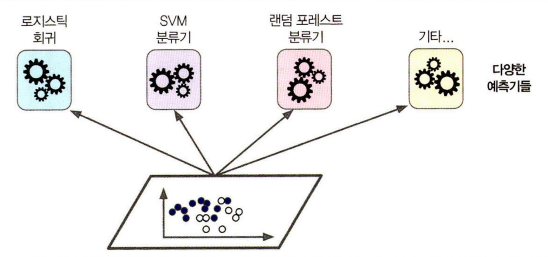 <br>
- `직접 투표 (hard voting)`: 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것 (다수결 투표)
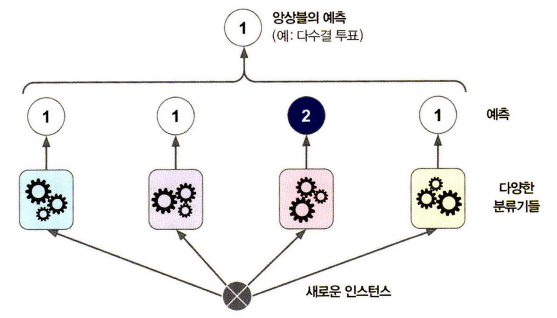 <br>
- 각 분류기가 약한 학습기(weak learner, 랜덤 추측보다 조금 더 높은 성능을 내는 분류기)일지라도 충분하게 많고 다양하다면 큰 수의 법칙에 의해 앙상블은 높은 정확도를 내는 강한 학습기(strong learner)가 될 수 있음
- 앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘하며 다양한 분류기를 얻는 한 가지 방법은 각기 다른 알고리즘을 학습시키는 것임
- 이렇게 하면 매우 다른 종류의 오차를 만들 가능성이 높기 때문에 앙상블 모델의 정확도를 향상시킴

In [1]:
#moons 데이터셋 로딩
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr',log_clf), ('rf',rnd_clf), ('svc',svm_clf)],
    voting='hard') #직접 투표
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [3]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test,y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.896


- 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높음
- 모든 분류기가 클래스의 확률을 예측할 수 있으면 (`predict_proba()` 메소드가 있으면), 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있고 이를 `간접 투표 (soft voting)`이라고 함
- 간접 투표는 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높음
- `voting='soft'`으로 파라미터 설정하고 모든 분류기가 클래스의 확률을 추정할 수 있으면 되는데, SVC는 기본값에서는 클래스 확률을 제공하지 않으므로 probability 매개변수를 True로 설정해야 함

In [4]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr',log_clf), ('rf',rnd_clf), ('svc',svm_clf)],
    voting='soft') #간접 투표
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('svc', SVC(probability=True))],
                 voting='soft')

In [5]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test,y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## 7.2 배깅과 페이스팅 <br>
- 다양한 분류기를 만드는 방법
    - 각기 다른 훈련 알고리즘 사용
    - 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시킴
<br><br>
- `배깅 (bagging, bootstrap aggregating)`: 훈련 세트에서 중복을 허용하여 샘플링하는 방식
- `페이스팅 (pasting)`: 중복을 허용하지 않고 샘플링하는 방식
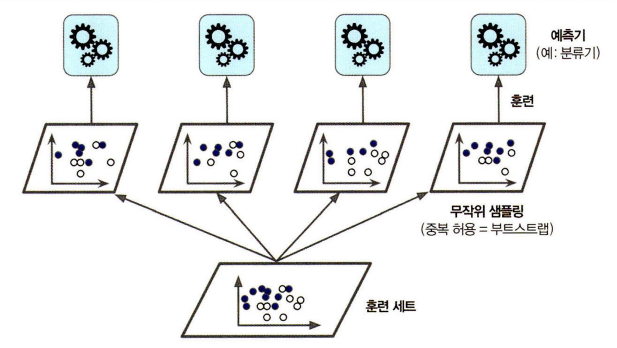
<br>
- 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듦
- 수집 함수는 전형적으로 분류일 때는 '통계적 최빈값'이고 회귀에 대해서는 '평균'을 계산함
- 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소함
- 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어듦

### 7.2.1 사이킷런의 배깅과 페이스팅 <br>
- 사이킷런은 배깅과 페이스팅을 위해 `BaggingClassifier`을 제공함 (회귀의 경우에는 `BaggingRegressor`)
- `bootstrap`이 True면 배깅, False면 페이스팅

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, #결정 트리 분류기 500개의 앙상블 훈련
    max_samples=100, bootstrap=True, n_jobs=-1) #훈련 세트에서 중복을 허용하여 무작위로 선택된 100개의 샘플 훈련 (배깅)
#n_jobs: 사이킷런이 훈련과 예측에 사용할 CPU 코어 수 지정 (-1이면 가용한 모든 코어 사용)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

#### 단일 결정 트리(왼쪽)와 500개 트리로 만든 배깅 앙상블(오른쪽) 비교
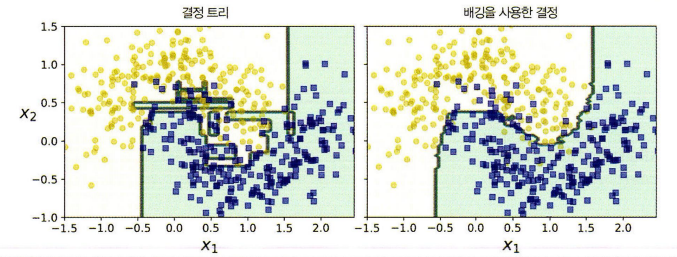
- 앙상블의 예측이 결정 트리 하나의 예측보다 일반화과 훨씬 잘됨
- 앙상블은 비슷한 편향에서 더 작은 분산을 만드므로 훈련 세트의 오차 수가 거의 비슷하지만 결정 경계는 덜 불규칙함
<br><br>
- 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높음
- 하지만 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킴
- 전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호함

### 7.2.2 oob 평가 <br>
- 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있음
- BaggingClassifier는 기본적으로 중복을 허용하여 (bootstrap=True) 훈련 세트의 크기만큼인 m개 샘플을 선택함
- 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링되며 선택되지 않은 훈련 샘플의 나머지 37%를 `oob (out-of-bag) 샘플`이라고 부름
- 예측기마다 남겨진 37%는 모두 다름
<br><br>
- 예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가할 수 있음
- 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻음

In [7]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True) #oob_score=True: 훈련이 끝난 후 자동으로 oob 평가 수행

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [8]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

In [10]:
bag_clf.oob_decision_function_ #oob 샘플에 대한 결정 함수의 값 (각 훈련 샘플의 클래스 확률 반환)
#첫 번째 훈련 샘플이 양성 클래스에 속할 확률: 0.59090909, 음성 클래스에 속할 확률: 0.40909091

array([[0.40909091, 0.59090909],
       [0.31213873, 0.68786127],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06341463, 0.93658537],
       [0.38172043, 0.61827957],
       [0.01075269, 0.98924731],
       [0.99428571, 0.00571429],
       [0.96842105, 0.03157895],
       [0.75280899, 0.24719101],
       [0.01086957, 0.98913043],
       [0.74585635, 0.25414365],
       [0.85135135, 0.14864865],
       [0.98870056, 0.01129944],
       [0.05263158, 0.94736842],
       [0.        , 1.        ],
       [0.98314607, 0.01685393],
       [0.94535519, 0.05464481],
       [0.98947368, 0.01052632],
       [0.03333333, 0.96666667],
       [0.32857143, 0.67142857],
       [0.91954023, 0.08045977],
       [1.        , 0.        ],
       [0.98351648, 0.01648352],
       [0.00537634, 0.99462366],
       [0.99408284, 0.00591716],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.63387978, 0.36612022],
       [0.

## 7.3 랜덤 패치와 랜덤 서브스페이스 <br>
- BaggingClassifier는 특성 샘플링도 지원하며 샘플링은 max_features, bootstrap_features 두 매개변수로 조절됨
- 작동 방식은 max_samples, bootstrap과 동일하지만 샘플이 아니고 특성에 대한 샘플링이므로 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련됨
- 이 기법은 이미지와 같은 매우 고차원의 데이터셋을 다룰 때 유용함
- `랜덤 패치 방식 (random patches method)`: 훈련 특성과 샘플을 모두 샘플링하는 것
- `랜덤 서브스페이스 방식 (random subspaces method)`: 훈련 샘플을 모두 사용하고 (bootstrap=False, max_samples=1.0) 특성은 샘플링하는 것 (bootstrap_features=True, max_features < 1.0)
- 특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춤

## 7.4 랜덤 포레스트 <br>
- 랜덤 포레스트는 일반적으로 배깅 방법 (또는 페이스팅)을 적용한 결정 트리의 앙상블로, 전형적으로 max_samples를 훈련 세트의 크기로 지정함
- Bagging Classifier에 DecisionTreeClassifier를 넣어 만드는 대신 결정 트리에 최적화되어 사용하기 편리한 RandomForestClassifier를 사용할 수 있음 (RandomForestRegressor: 회귀 문제)


In [11]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1) #최대 16개의 리프 노드를 갖는 500개 트리로 이뤄진 랜덤 포레스트 분류기
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

- 랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입함
- 이는 결국 트리를 더욱 다양하게 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어냄

In [12]:
#BaggingClassifier를 사용해 앞의 RandomForestClassifier와 거의 유사하게 만든 것
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

### 7.4.1 엑스트라 트리 <br>
- 랜덤 포레스트에서 트리를 만들 때 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용함
- 트리를 더욱 무작위하게 만들기 위해 최적의 임계값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택함
<br><br>
- 이와 같이 극단적으로 무작위한 트리의 랜덤 포레스트를 `익스트림 랜덤 트리 앙상블 (extremely randomized trees, 엑스트라 트리)`라고 부름
- 여기서도 편향이 늘어나지만 대신 분산을 낮추게 됨
- 모든 노드에서 특성마다 가장 최적의 임계값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업 중 하나이므로 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠름
<br><br>
- 엑스트라 트리를 만들려면 사이킷런의 ExtraTreesClassifier를 사용함 (ExtraTreesRegressor: 회귀 문제)

### 7.4.2 특성 중요도 <br>
- 랜덤 포레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것임
- 사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정함
- 더 정확히 말하면, 가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플 수와 같음
<br><br>
- 사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결과값을 정규화하며 이 값은 feature_importances_ 변수에 저장되어 있음

In [14]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09521863997076549
sepal width (cm) 0.022989396420547505
petal length (cm) 0.4386593537043249
petal width (cm) 0.44313260990436226


#### 랜덤 포레스트 분류기에서 얻은 MNIST 픽셀 중요도 <br>
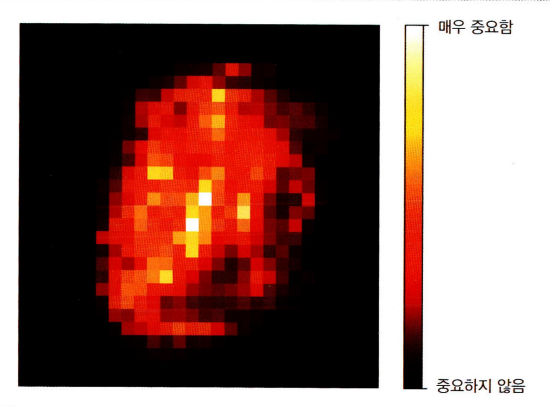

## 7.5 부스팅 <br>
- `부스팅 (boosting)`: 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법
- 부스팅 방법의 아이디어는 앞의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것임
- 부스팅 방법 중 가장 인기 있는 것은 `에이다부스트 (AdaBoost)`와 `그레이디언트 부스팅 (Gradient boosting)`임

### 7.5.1 에이다부스트 <br>
- 이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것임
- 이렇게 하면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 되며 이것이 에이다부스트에서 사용하는 방식임
<br><br>
- 예를 들어, 에이다부스트 분류기를 만들 때 먼저 알고리즘이 기반이 되는 첫 번째 분류기를 훈련 세트에서 훈련시키고 예측을 만듦
- 그 다음에 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높임
- 두 번째 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만들고 다시 가중치를 업데이트함
<br><br>

#### 샘플의 가중치를 업데이트하면서 순차적으로 학습하는 에이다부스트
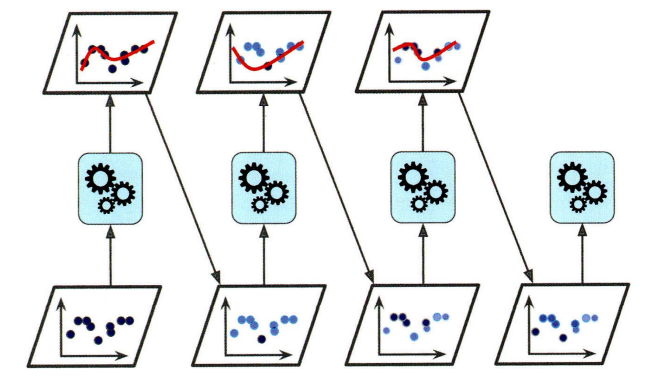
<br><br>

#### 연속된 예측기의 결정 경계
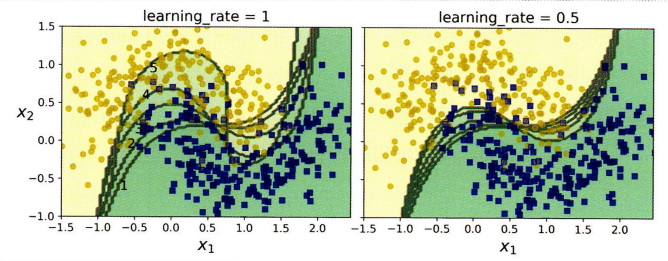
- 첫 번째 분류기가 많은 샘플을 잘못 분류해서 이 샘플들의 가중치가 높아져서 두 번째 분류기는 이 샘플들을 더 정확히 예측하게 됨
- 오른쪽 그래프는 학습률을 반으로 낮춘 것만 빼고 똑같은 일련의 예측기임 (잘못 분류된 샘플의 가중치는 반복마다 절반 정도만 높아짐)
- 이러한 연속된 학습 기법은 경사 하강법과 비슷한 면이 있음
- 경사 하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해가는 반면, 에이다부스트는 점차 더 좋아지도록 앙상블에 예측기를 추가함
- 각 예측기는 이전 예측기가 훈련되고 평가된 후에 학습할 수 있기 때문에 병렬화를 할 수 없어서 배깅이나 페이스팅만큼 확장성이 높지 않음
<br><br>

#### j번째 예측기의 가중치가 적용된 에러율
$$ r_j = \frac{\underset{\hat{y}^{(i)}_j \neq y^{(i)}}{\sum_{i=1}^mw^{(i)}}}{\sum^m_{i=1}w^{(i)}} \space \space \space \space여기서 \hat{y}^{(i)}_j는 \space i번째 \space 샘플에 \space 대한 \space j번째 \space 예측기의 \space 예측 $$
- 각 샘플 가중치 $w^{(i)}$는 초기에 $\frac1m$로 초기화됨
- 첫 번째 예측기가 학습되고, 가중치가 적용된 에러율 $r_1$이 훈련 세트에 대해 계산됨
<br><br>

#### 예측기 가중치
$$ α_j = ηlog\frac{1-r_j}{r_j} $$
- 예측기의 가중치 $α_j$는 위 식을 사용해 계산되며 $η$는 학습률 파라미터임 (기본값 1)
- 예측기가 정확할수록 가중치가 더 높아지며 만약 무작위로 예측하는 정도라면 가중치가 0에 가까울 것임
- 그러나 그보다 나쁘면 (무작위 추측보다 정확도가 낮으면) 가중치는 음수가 됨
<br><br>

#### 가중치 업데이트 규칙
$$ w^{(i)} \leftarrow \begin{cases} w^{(i)} & \hat{y_j}^{(i)} = y^{(i)}일 \space 때 \\ w^{(i)}exp(α_j) & \hat{y_j}^{(i)} \neq y^{(i)}일 \space 때 \end{cases} \\ 여기서 \space i=1,2,\cdots,m $$
- 에이다부스트 알고리즘이 위 식을 사용해 가중치를 업데이트한 후 모든 샘플의 가중치를 정규화함 ($\sum^m_{i=1}w^{(i)}$으로 나눔)
- 마지막으로 새 예측기가 업데이트된 가중치를 사용해 훈련되고 전체 과정이 반복됨
- 이 알고리즘은 지정된 예측기 수에 도달하거나 완벽한 예측기가 만들어지면 중지됨
<br><br>

#### 에이다부스트 예측
$$ \hat{y}(x) = \underset{k}{argmax} \sum^N_{\underset{\hat{y_j}(x)=k}{j=1}} α_j $$
- 예측을 할 때 에이다부스트는 단순히 모든 예측기의 예측을 계산하고 예측기 가중치 $α_j$를 더해 예측 결과를 만듦
- 가중치 합이 가장 큰 클래스가 예측 결과가 됨
<br><br>
- 사이킷런은 SAMME라는 에이다부스트의 다중 클래스 버전을 사용하며, 클래스가 두 개 뿐일 때는 SAMME가 에이다부스트와 동일함
- 예측기가 클래스의 확률을 추정할 수 있다면 (predict_proba() 메소드가 있다면) 사이킷런은 SAMME.R(끝의 R: 'Real')이라는 SAMME의 변종을 사용함
- 이 알고리즘은 예측값 대신 클래스 확률에 기반하며 일반적으로 성능이 더 좋음

In [19]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, #max_depth=1: 결정 노드 하나와 리프 노드 2개로 이루어진 트리 (기본 추정기)
    algorithm='SAMME.R', learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### 7.5.2 그레이디언트 부스팅 <br>
- 그레이디언트 부스팅은 에이다부스트처럼 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가함
- 하지만 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔여 오차 (residual error)에 새로운 예측기를 학습시킴

In [31]:
#잡음이 섞인 2차 곡선 형태의 훈련 세트
import numpy as np

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)
X_new = np.array([[0.8]])

In [32]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y) #DecisionTreeRegressor를 훈련 세트에 학습

DecisionTreeRegressor(max_depth=2)

In [33]:
y2 = y - tree_reg1.predict(X) #잔여 오차
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2)

In [34]:
y3 = y2 - tree_reg2.predict(X) #잔여 오차
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

In [35]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1,tree_reg2,tree_reg3))

#### 세 트리의 예측 (왼쪽 열)과 앙상블의 예측 (오른쪽 열)
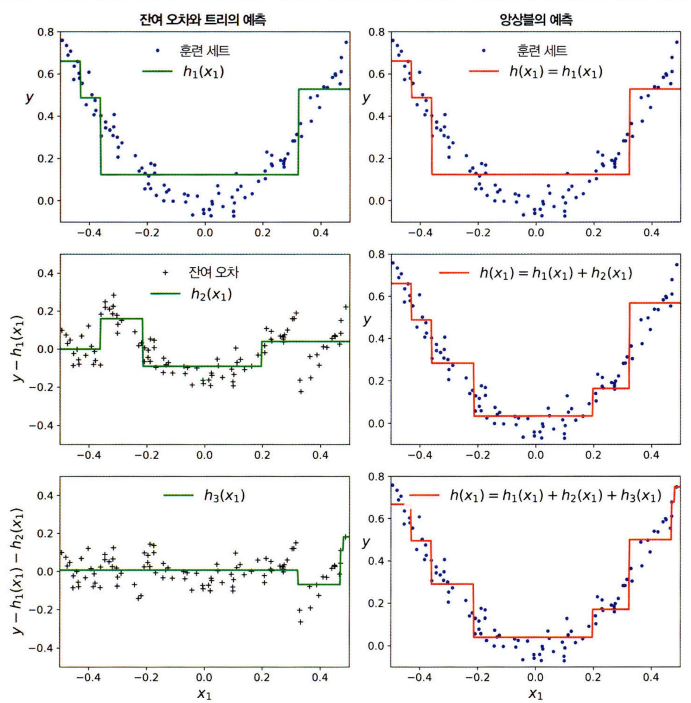
- 이 그래이디언트 부스팅 그래프에서 첫 번째 예측기(왼쪽 위)가 평소와 같이 훈련됨
- 그 다음 연이은 예측기(왼쪽 중간, 왼쪽 아래)가 이전의 예측기의 잔여 오차에서 훈련됨
- 오른쪽 열은 만들어진 앙상블의 예측을 보여줌
- 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아짐

In [36]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0) #learning_rate: 각 트리의 기여 정도
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

- learning_rate을 0.1처럼 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아짐
- 이는 `축소 (shrinkage)`라고 부르는 규제 방법임
<br><br>

#### 예측기가 부족한 경우(왼쪽)와 너무 많은 경우(오른쪽)의 GBRT 앙상블
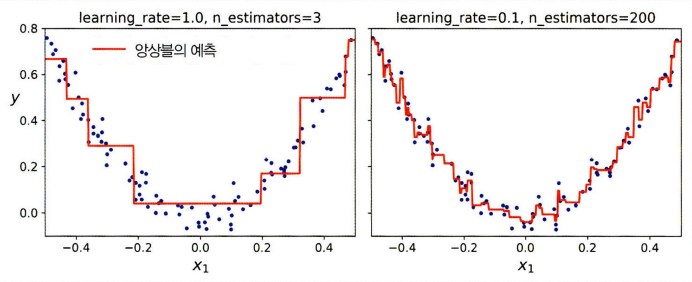
- 오른쪽은 트리가 너무 많아 훈련 세트에 과대적합됨

In [37]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120) #120개의 트리로 GBRT 앙상블 훈련
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
         for y_pred in gbrt.staged_predict(X_val)] #staged_predict(): 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자 반환 (조기 종료 구현)
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=85)

#### 조기 종료를 사용하여 트리 수 튜닝
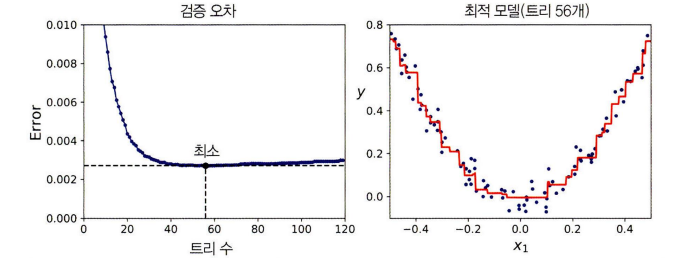

In [39]:
gbrt = GradientBoostingRegressor(max_depth=1, warm_start=True) #warm_start=True: 사이킷런이 fit() 메소드가 호출될 때 기존 트리를 유지하고 훈련할 수 있도록 해줌

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1,120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break #조기 종료

- GradientBoostingRegressor는 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정할 수 있는 subsample 매개변수도 지원함
- 예를 들어, subsample=0.25라고 하면 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습되며 편향이 높아지는 대신 분산이 낮아짐
- 또한 훈련 속도를 상당히 높이며 이런 기법을 `확률적 그레이디언트 부스팅 (stochastic gradient boosting)`이라고 함
<br><br>
- 최적화된 그레이디언트 부스팅 구현으로 XGBoost (익스트림 그레이디언트 부스팅) 파이썬 라이브러리가 유명함

In [40]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [42]:
xgb_reg.fit(X_train, y_train,
           eval_set=[(X_val, y_val)], early_stopping_rounds=2) #자동 조기 종료
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.22055
[1]	validation_0-rmse:0.16547
[2]	validation_0-rmse:0.12243
[3]	validation_0-rmse:0.10044
[4]	validation_0-rmse:0.08467
[5]	validation_0-rmse:0.07344
[6]	validation_0-rmse:0.06728
[7]	validation_0-rmse:0.06383
[8]	validation_0-rmse:0.06125
[9]	validation_0-rmse:0.05959
[10]	validation_0-rmse:0.05902
[11]	validation_0-rmse:0.05852
[12]	validation_0-rmse:0.05844
[13]	validation_0-rmse:0.05801
[14]	validation_0-rmse:0.05747
[15]	validation_0-rmse:0.05772


## 7.6 스태킹 <br>
- `스태킹 (stacked generalization)`: 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신 취합하는 모델을 훈련시킨다는 아이디어에서 출발한 앙상블 모델
<br><br>

#### 블렌딩 예측기를 사용한 예측 취합
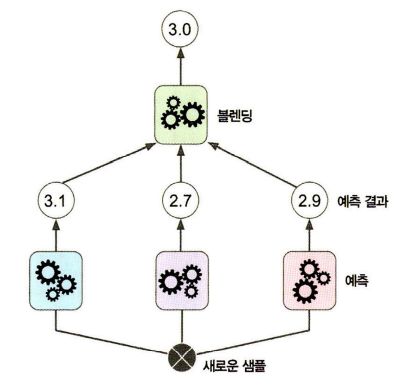
- 세 예측기는 각각 다른 값(3.1, 2.7, 2.9)을 예측하고 마지막 예측기 (블렌더, 메타 학습기)가 이 예측을 입력으로 받아 최종 예측(3.0)을 만듦
<br><br>

#### 첫 번째 레이어 훈련하기
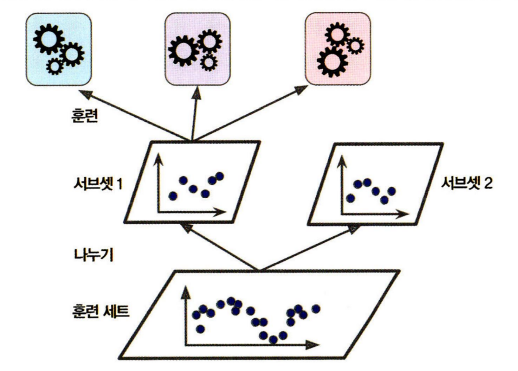
- 블렌더를 학습시키는 일반적인 방법은 '홀드 아웃 세트'를 사용하는 것임
- 먼저 훈련 세트를 두 개의 서브셋으로 나누며 첫 번째 서브셋은 첫 번째 레이어의 예측을 훈련시키기 위해 사용됨
<br><br>

#### 블렌더 훈련
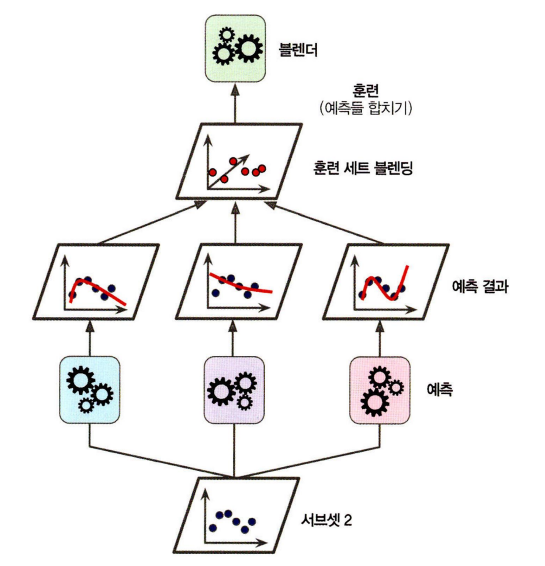
- 그 다음 첫 번째 레이어의 예측기를 사용해 두 번째 홀드 아웃 세트에 대한 예측을 만듦
- 예측기들이 훈련하는 동안 이 샘플들을 전혀 보지 못했기 때문에 이때 만들어진 예측값은 완전히 새로운 것임
- 홀드 아웃 세트의 각 샘플에 대해 세 개의 예측값이 있으며 타깃값은 그대로 쓰고 앞에서 예측한 값을 입력 특성으로 사용하는 새로운 훈련 세트를 만들 수 있음 (새로운 훈련 세트는 3차원이 됨)
- 블렌더가 새 훈련 세트로 훈련되므로 첫 번째 레이어의 예측을 가지고 타깃값을 예측하도록 학습됨
<br><br>

#### 멀티 레이어 스태킹 앙상블의 예측
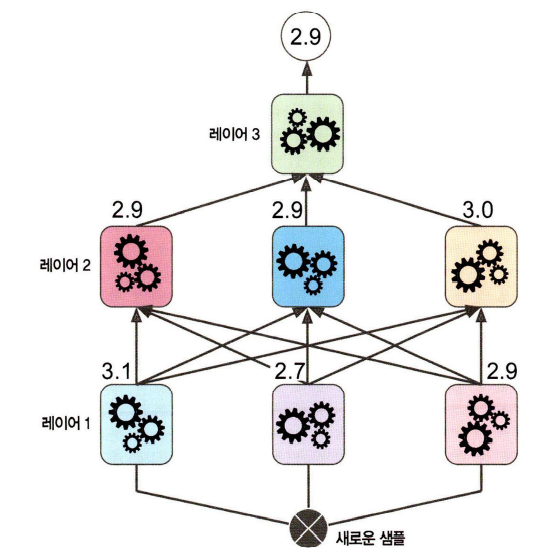
- 이런 방식의 블렌더를 여러 개 훈련시키는 것도 가능함 (예를 들어 하나는 선형 회귀, 하나는 랜덤 포레스트 회귀)
- 그러면 블렌더만의 레이어가 만들어짐
- 이렇게 하려면 훈련 세트를 세 개의 서브셋으로 나누고 첫 번째 세트는 첫 번째 레이어를 훈련시키는 데 사용되고 두 번째 세트는 첫 번째 레이어의 예측기로 두 번째 레이어를 훈련시키기 위한 훈련 세트를 만드는 데 사용됨
- 세 번째 세트는 두 번째 레이어의 예측기로 세 번째 레이어를 훈련시키기 위한 훈련 세트를 만드는 데 사용됨
- 작업이 끝나면 위처럼 각 레이어를 차례대로 실행해서 새로운 샘플에 대한 예측을 만들 수 있음
<br><br>
- 사이킷런은 스태킹을 직접 지원하지는 않지만 직접 구현할 수 있음
- DESlib (https://github.com/Menelau/DESlib) 오픈 소스 참고